# Importar datos

In [1]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
License(s): CC0-1.0
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 3.09MB/s]


In [2]:
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


In [3]:
import pandas as pd
df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


# Datos de entrenamiento

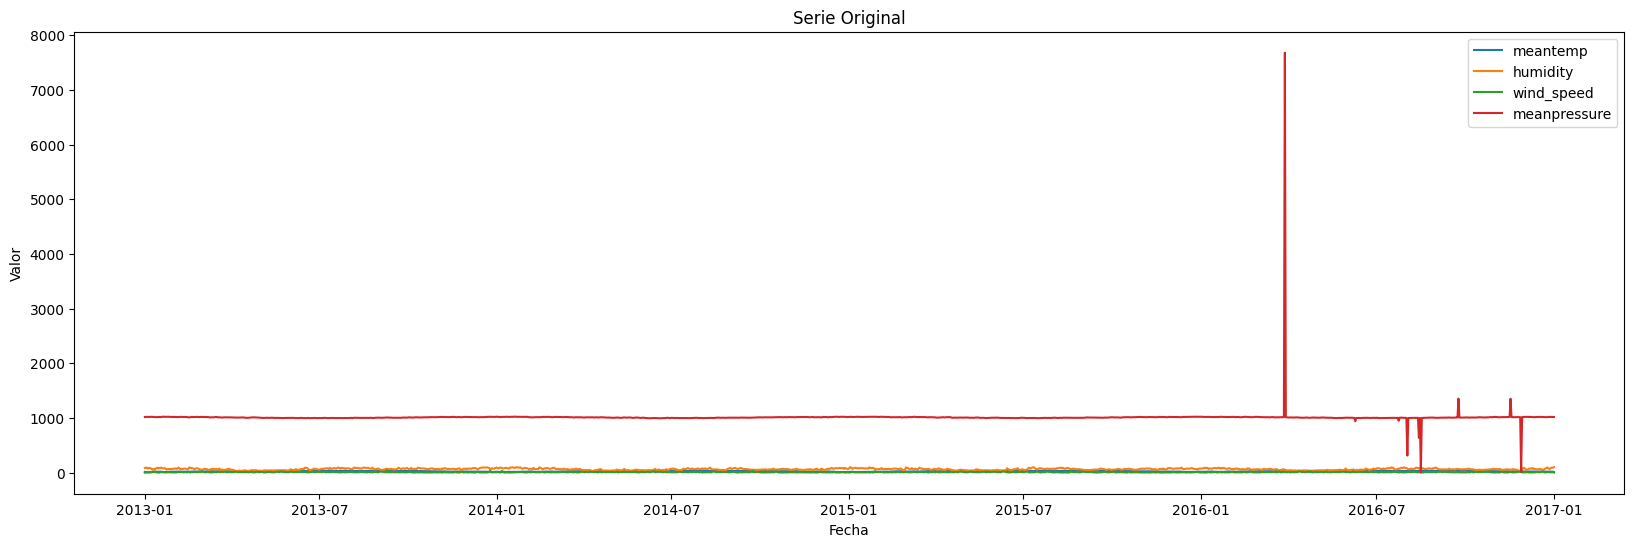

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
plt.figure(figsize=(20, 6))
plt.plot(df_train, label=df_train.columns)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie Original')
plt.legend()
plt.show()

In [8]:
descomposition = seasonal_decompose(df_train[['meantemp']], model='additive')

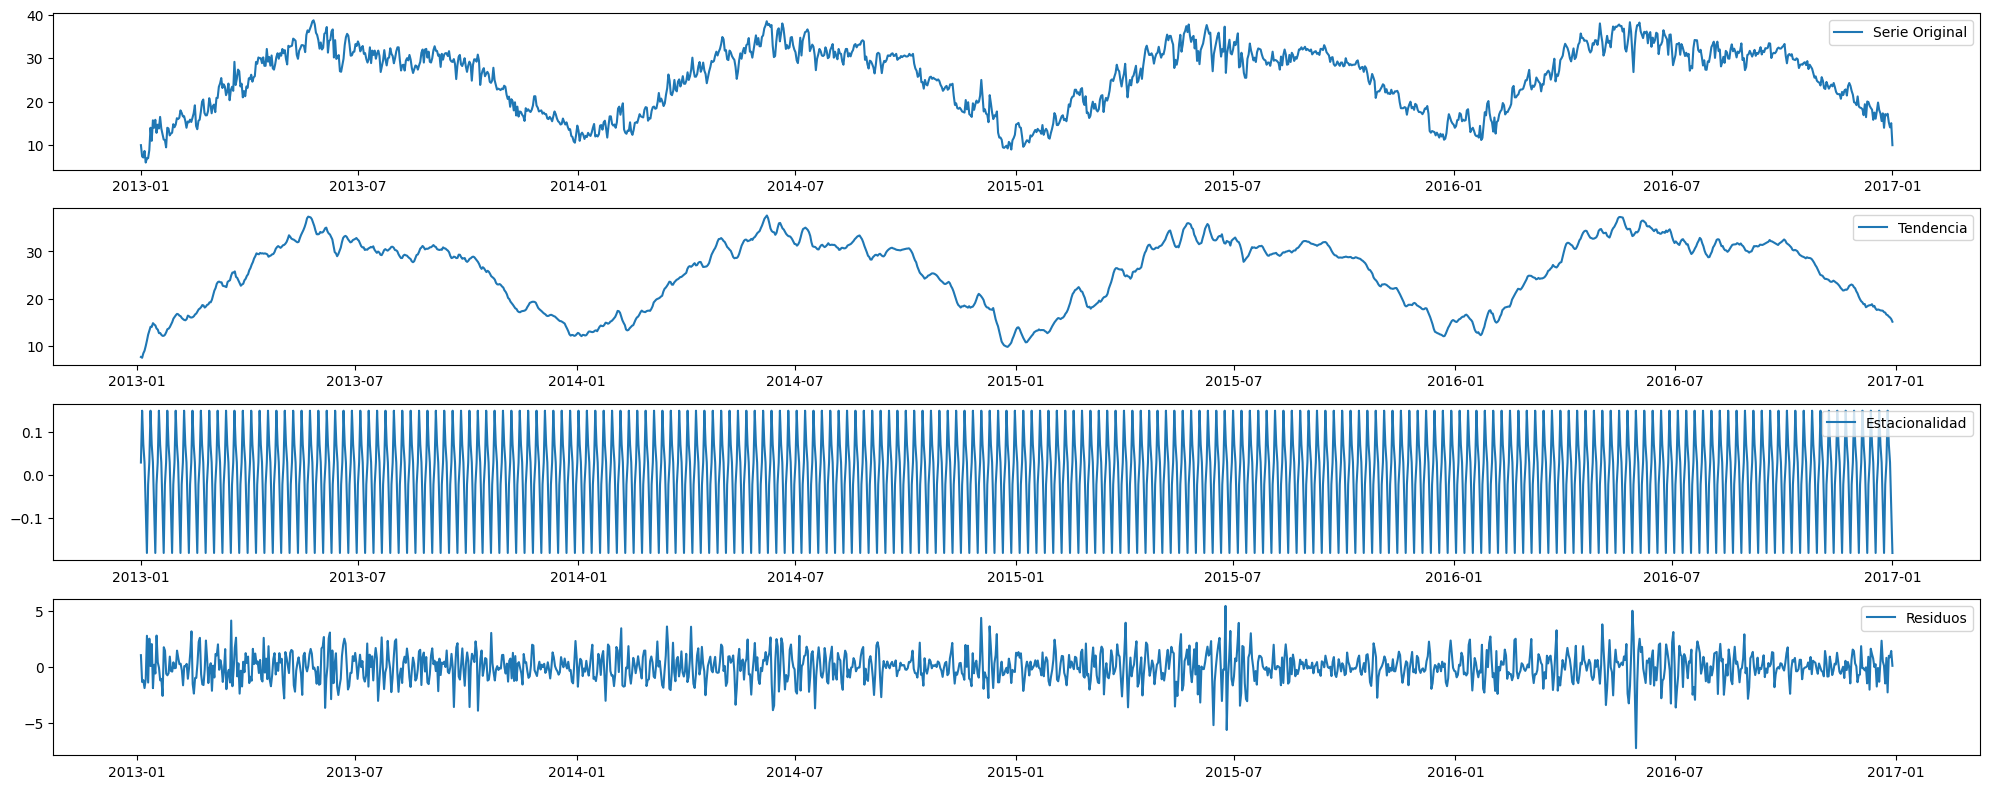

In [9]:
plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(df_train[['meantemp']], label='Serie Original')
plt.legend()

plt.subplot(412)
plt.plot(descomposition.trend, label='Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(descomposition.seasonal, label='Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(descomposition.resid, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()

# Datos de test

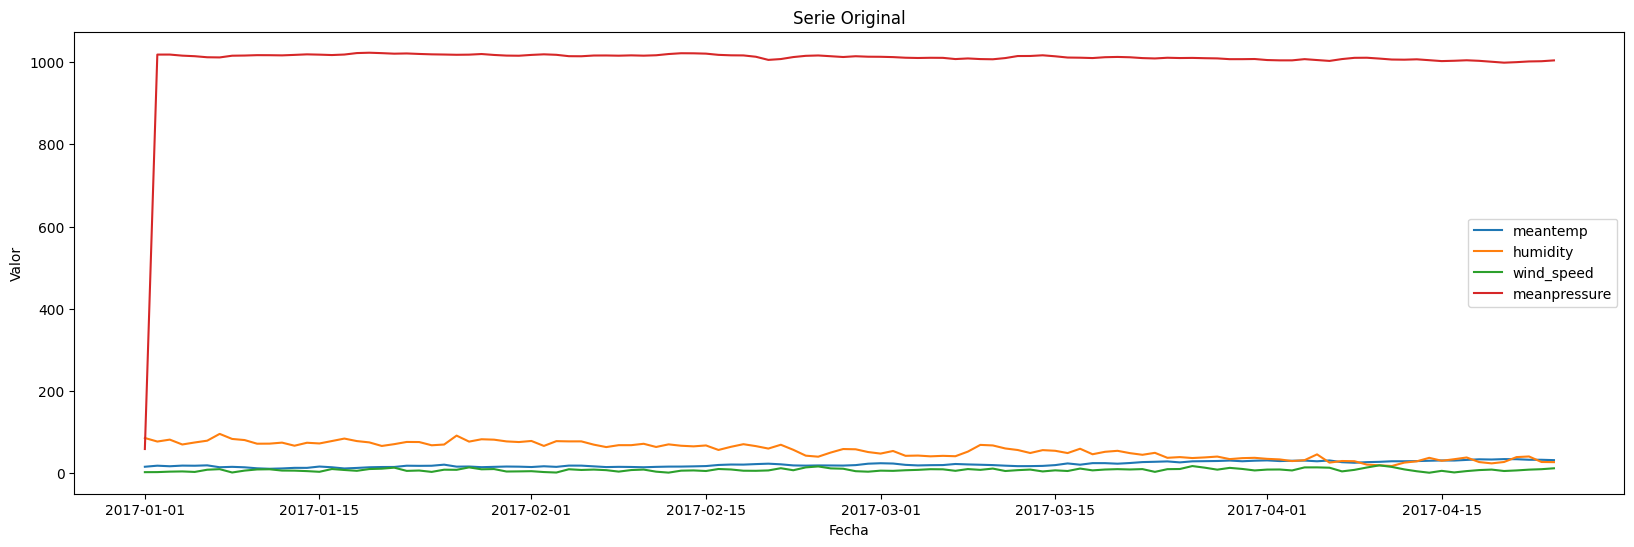

In [10]:

plt.figure(figsize=(20, 6))
plt.plot(df_test, label=df_test.columns)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie Original')
plt.legend()
plt.show()

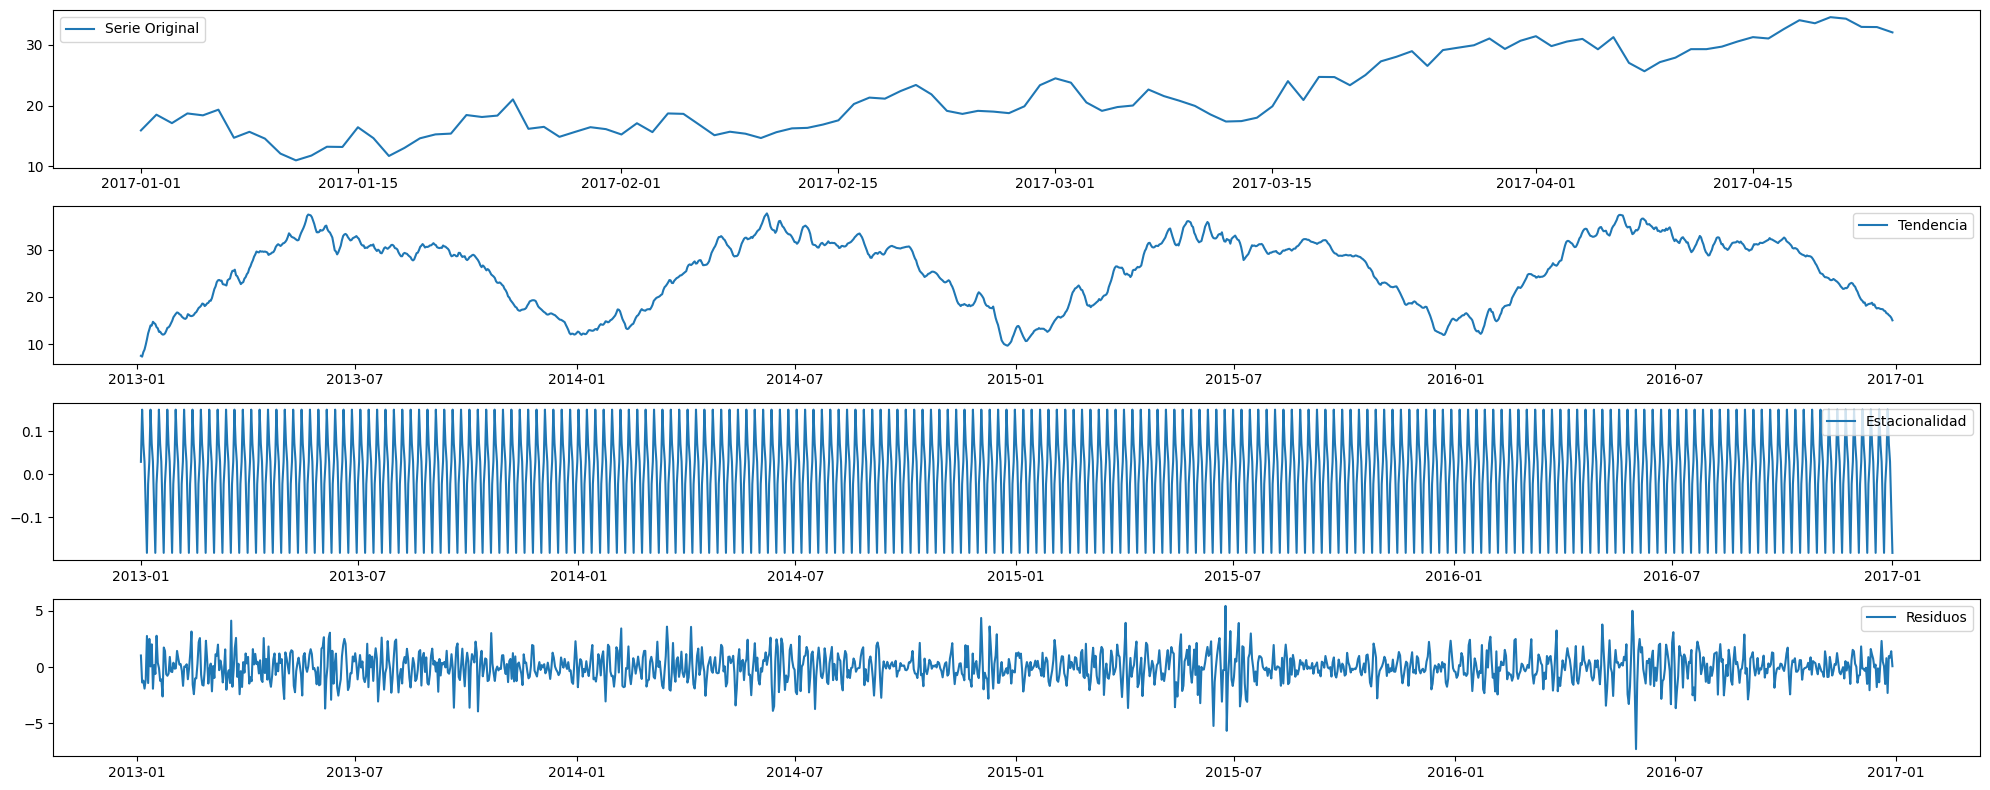

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(df_test[['meantemp']], label='Serie Original')
plt.legend()

plt.subplot(412)
plt.plot(descomposition.trend, label='Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(descomposition.seasonal, label='Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(descomposition.resid, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
data_train = df_train[['meantemp']]
data_test = df_test[['meantemp']]

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
data_scaled_test = scaler.fit_transform(data_test)

# Función para crear secuencias de tiempo
def crear_secuencias(data, pasos):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i + pasos])
        y.append(data[i + pasos])
    return np.array(X), np.array(y)

# Número de pasos en la secuencia (ventana deslizante)
pasos = 50

# Crear secuencias para el conjunto de entrenamiento
X_train, y_train = crear_secuencias(data_scaled, pasos)

# Crear secuencias para el conjunto de prueba
X_test, y_test = crear_secuencias(data_scaled_test, pasos)



# Model LSTM

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
# Modelo LSTM con más capas
model_lstm = Sequential()

# Primera capa LSTM con return_sequences=True para que la salida sea usada en la siguiente capa LSTM
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Segunda capa LSTM
model_lstm.add(LSTM(units=50, return_sequences=True))

# Tercera capa LSTM
model_lstm.add(LSTM(units=50))

# Capa de salida
model_lstm.add(Dense(1))

# Compilar el modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Hacer predicciones
predicciones_lstm = model_lstm.predict(X_test)
predicciones_lstm = scaler.inverse_transform(predicciones_lstm)




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0711
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0077
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0068
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0064
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0059
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0054
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0060
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0063
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0052
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0051
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0050
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0063
Epoch 13/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0052
Epoch 14/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0049
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0049
Epoch 16/20
4

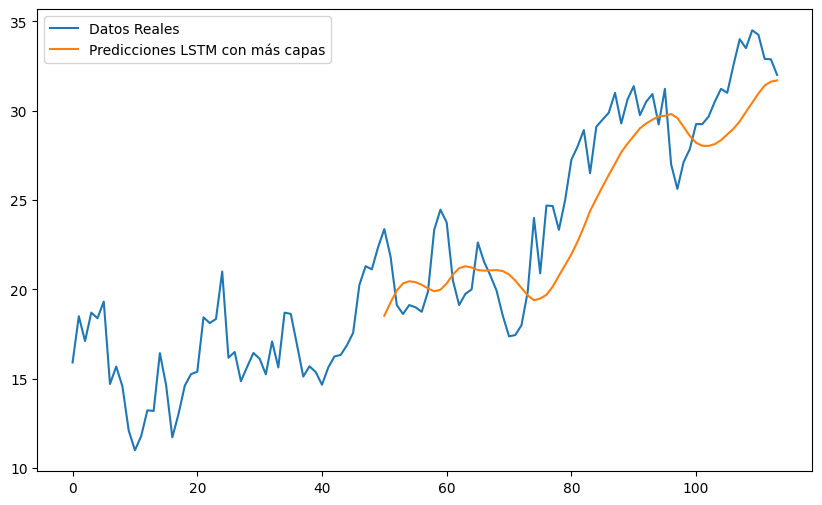

In [15]:
# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data_test)), data_test, label='Datos Reales')
plt.plot(np.arange(len(data_test) - len(predicciones_lstm), len(data_test)), predicciones_lstm, label='Predicciones LSTM con más capas')
plt.legend()
plt.show()


# Métricas

MAE: 2.437494874035615
RMSE: 2.842980739772862
MAPE: 9.50119887517576%
R²: 0.6959753062519751
    Predicciones  Valores Reales   Errores
0      18.530903       23.375000  4.844097
1      19.269888       21.833333  2.563445
2      19.940027       19.125000 -0.815027
3      20.337002       18.625000 -1.712002
4      20.458366       19.125000 -1.333366
..           ...             ...       ...
59     30.446215       34.500000  4.053785
60     30.965967       34.250000  3.284033
61     31.404902       32.900000  1.495098
62     31.625202       32.875000  1.249798
63     31.695793       32.000000  0.304207

[64 rows x 3 columns]


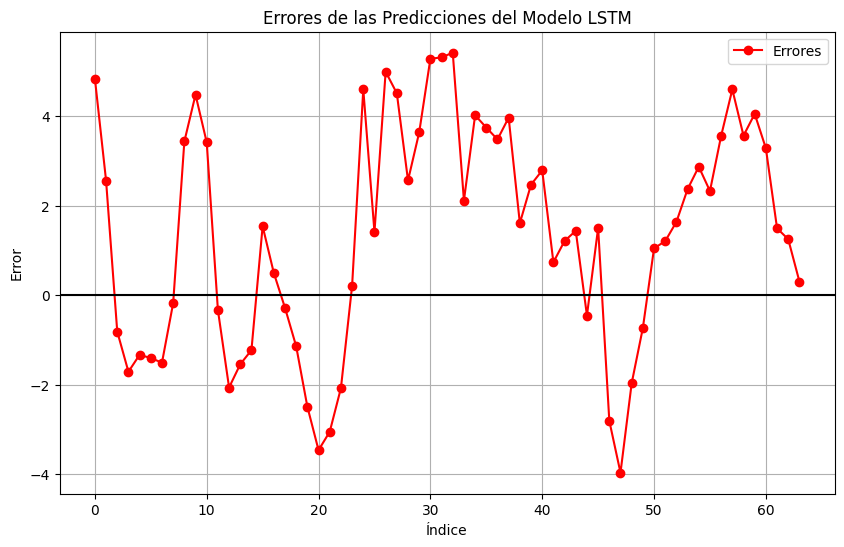

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
ytest=scaler.inverse_transform(y_test)


mae = mean_absolute_error(ytest, predicciones_lstm)
rmse = np.sqrt(mean_squared_error(ytest, predicciones_lstm))
mape = np.mean(np.abs((ytest - predicciones_lstm) / ytest)) * 100
r2 = r2_score(ytest, predicciones_lstm)

# Imprimir las métricas
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

# Cálculo de los errores (residuos)
errors = ytest - predicciones_lstm

# Crear un DataFrame para las predicciones, valores reales y errores
resultados = pd.DataFrame({
    'Predicciones': predicciones_lstm.flatten(),  # Aplanar el array si es necesario
    'Valores Reales': ytest.flatten(),
    'Errores': errors.flatten()
})

# Imprimir la tabla con las predicciones, valores reales y errores
print(resultados)

# Graficar los errores
plt.figure(figsize=(10, 6))
plt.plot(resultados['Errores'], marker='o', linestyle='-', color='r', label='Errores')
plt.axhline(0, color='black', linewidth=1.5)  # Línea en el cero para facilitar la visualización
plt.title('Errores de las Predicciones del Modelo LSTM')
plt.xlabel('Índice')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Model GRU

In [42]:
# Modelo GRU con más capas
model_gru = Sequential()

# Primera capa GRU con return_sequences=True para que la salida sea usada en la siguiente capa GRU
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Segunda capa GRU
model_gru.add(GRU(units=50, return_sequences=True))

# Tercera capa GRU
model_gru.add(GRU(units=50))

# Capa de salida
model_gru.add(Dense(1))

# Compilar el modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Hacer predicciones
predicciones_gru = model_gru.predict(X_test)
predicciones_gru = scaler.inverse_transform(predicciones_gru)




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.1215
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0061
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0037
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0037
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0038
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0037
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0038
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0033
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0029
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0030
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0031
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0029
Epoch 13/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0029
Epoch 14/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0032
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0028
Epoch

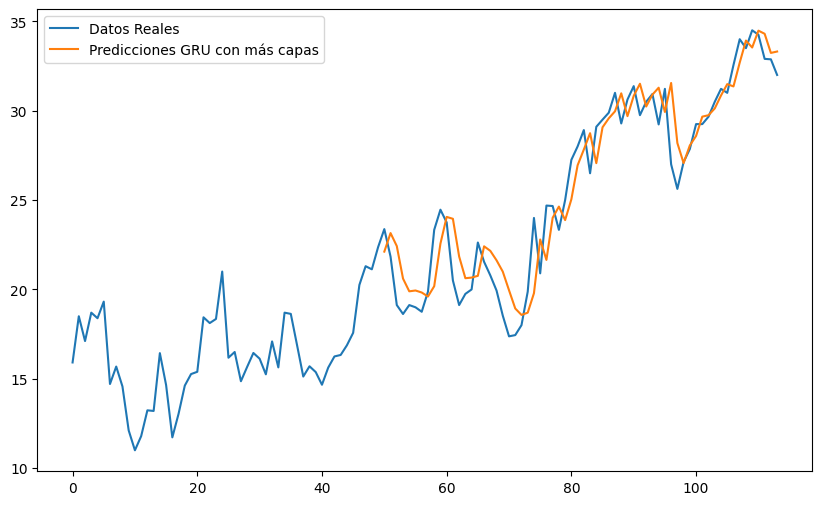

In [43]:
# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data_test)), data_test, label='Datos Reales')
plt.plot(np.arange(len(data_test) - len(predicciones_gru), len(data_test)), predicciones_gru, label='Predicciones GRU con más capas')
plt.legend()
plt.show()

# Métricas

MAE: 1.3472996109584447
RMSE: 1.6860996996393043
MAPE: 5.696013579436066%
R²: 0.8930631156213801
    Predicciones  Valores Reales   Errores
0      22.115572       23.375000  1.259428
1      23.152658       21.833333 -1.319325
2      22.425531       19.125000 -3.300531
3      20.606680       18.625000 -1.981680
4      19.894255       19.125000 -0.769255
..           ...             ...       ...
59     33.535988       34.500000  0.964012
60     34.478878       34.250000 -0.228878
61     34.303814       32.900000 -1.403814
62     33.233456       32.875000 -0.358456
63     33.311840       32.000000 -1.311840

[64 rows x 3 columns]


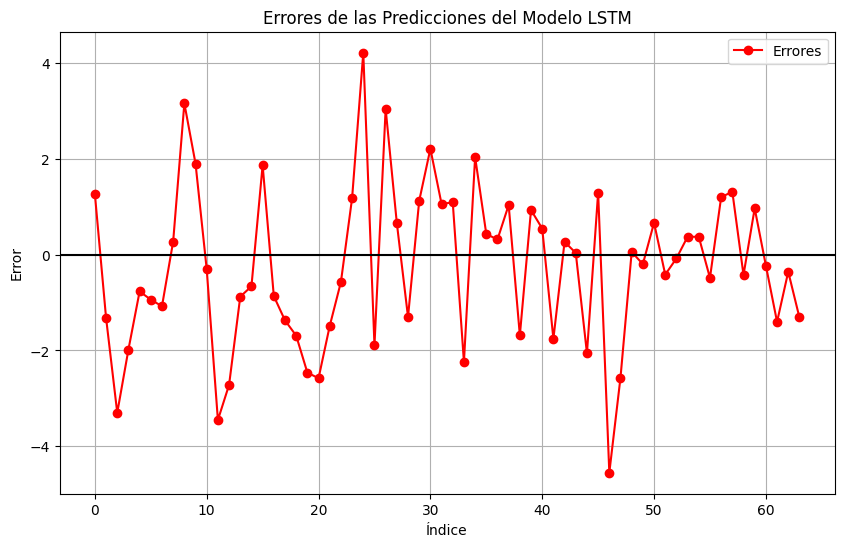

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
ytest=scaler.inverse_transform(y_test)


mae = mean_absolute_error(ytest, predicciones_gru)
rmse = np.sqrt(mean_squared_error(ytest, predicciones_gru))
mape = np.mean(np.abs((ytest - predicciones_gru) / ytest)) * 100
r2 = r2_score(ytest, predicciones_gru)

# Imprimir las métricas
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

# Cálculo de los errores (residuos)
errors = ytest - predicciones_gru

# Crear un DataFrame para las predicciones, valores reales y errores
resultados = pd.DataFrame({
    'Predicciones': predicciones_gru.flatten(),  # Aplanar el array si es necesario
    'Valores Reales': ytest.flatten(),
    'Errores': errors.flatten()
})

# Imprimir la tabla con las predicciones, valores reales y errores
print(resultados)

# Graficar los errores
plt.figure(figsize=(10, 6))
plt.plot(resultados['Errores'], marker='o', linestyle='-', color='r', label='Errores')
plt.axhline(0, color='black', linewidth=1.5)  # Línea en el cero para facilitar la visualización
plt.title('Errores de las Predicciones del Modelo LSTM')
plt.xlabel('Índice')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()